In [3]:
from pyhive import presto
import operator

def get_presto_conn():
    return presto.connect(host='presto-alpha-backend.data.houzz.net', port=8086)

def presto_query(query, presto_conn, fetchall=True):
    cursor = presto_conn.cursor()
    cursor.execute(query)
    header = list(map(operator.itemgetter(0), cursor.description))
    return header, cursor.fetchall()

conn = get_presto_conn() # establish the connection

# Or if want to use df format

import pandas as pd

#df = pd.read_sql_query(q, conn)

## [Shap values for AB Testing](https://medium.com/indeed-engineering/shap-plots-the-crystal-ball-for-ui-test-ideas-121838d917f5)

- Feature Engineering (Parts of UI click or impression)
- Target Variable (Objective of the page)
- A threshold for enough accuracy
- Shap plots and other visualization for decision makings

**Example**: `browse_guided_nav_web`   
**Type**: Browse Products   
**Objective**: Add to cart & Order

### Two models:
    - One for control
    - One for treatment

### Features

- Quiz take
    - Top, Inline, Retake
    - See results
- Filters Engaged (comp_id = 'see_all_filters')
- comp_id breadrumblink (back to last level)
- comp_id tag-popular-filter
- comp_id searchSubmit
- comp_id camera-icon
- comp_id free_shipping 
- scope_id headerv6

## Future Framework

**Take input of scope_id or comp_id then do the calculation & modeling then show results for interpretation**

In [130]:
q = '''
select t.test_variant
    , t.visitor_id
    , t.session_id
    , t.cart_add
    , t.checkout_order_confirmation
    , sum(case when scope_id in ('browse_guided_nav_top','browse_guided_nav_inline','browse_guided_nav_retake')
        then 1 else 0 end) quiz_taken
    , sum(case when comp_id = 'see_all_filters' then 1 else 0 end) filters_applied
    , sum(case when scope_id = 'hz-browse-popular-filters' then 1 else 0 end) popular_filters_applied
    , sum(case when comp_id = 'searchSubmit' then 1 else 0 end) search_applied
    , sum(case when scope_id = 'topics_nav_module' then 1 else 0 end) topics_applied
    , sum(case when scope_id like 'browse_recently_viewed%' then 1 else 0 end) recently_viewed
    , sum(case when scope_id = 'category_landing_entrypoints' then 1 else 0 end) category_landing_entrypoints
from abtest.visitor_test_metrics_daily_comp t
    inner join l2.page_views_daily l1
        on l1.session_id = t.session_id
            and t.visitor_id = l1.visitor_id
            and t.dt = l1.dt
    left join l2.page_transition_daily l2
        on t.session_id = l2.session_id
            and l2.visitor_id = t.visitor_id
            and l2.dt = t.dt
            and l2.dt >= '2022-04-28'
where test_name in ('browse_guided_nav_web')
    and test_variant in ('treatment_a','treatment_b')
    and l1.dt >= '2022-04-28'
    and t.dt >= '2022-04-28'
    and l1.topic in (430,469,969,607,13149)
group by 1,2,3,4,5
order by 1,2,3,4,5
'''

In [131]:
%%time
data = pd.read_sql_query(q, conn)

data

CPU times: user 560 ms, sys: 294 ms, total: 854 ms
Wall time: 1min 1s


,test_variant,visitor_id,session_id,cart_add,checkout_order_confirmation,quiz_taken,filters_applied,popular_filters_applied,search_applied,topics_applied,recently_viewed,category_landing_entrypoints
0,treatment_a,00024b4d-e55c-4c93-9dba-f336e05b7e99,5c99ce42c49da1df1b598b03a8938e94,0,0,7,0,0,0,0,0,0
1,treatment_a,00024b4d-e55c-4c93-9dba-f336e05b7e99,de523bf6b433711d54eb31a95a5d7996,0,0,0,0,0,0,0,0,0
2,treatment_a,00085aa6-6e2d-47d8-90a8-99b7b48f339d,85488c28696063e3fc18e12f8e17ee96,0,0,9,0,0,0,0,0,0
3,treatment_a,0008d83a-9a8b-4e2b-bf5f-30ac5ad9a8f9,7ec8126c7152be7cdeeacabfc0a5818e,0,0,0,0,0,1,1,0,0
4,treatment_a,0008ddbc-034d-40f3-8341-7ae94b18cd20,af610864fb9b2e9f7162db300712c0de,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
57100,treatment_b,fff42eef-eb1c-473c-8f68-079964e3f851,722ea787dd40a976015de682af682cc1,0,0,0,0,0,0,0,0,0
57101,treatment_b,fff6e1fa-c6e5-44a6-9989-2ecab9aa9ff9,fb44f5e71aeea60d6c36012f3000ee37,0,0,0,0,0,0,0,0,0
57102,treatment_b,fffc8011-396a-4f00-9c80-41134458aa59,f7af9fffa8086aa3c3fb299e7c395e39,0,0,0,0,0,0,0,0,0
57103,treatment_b,ffff2356-340f-4ce2-bbc5-e2d43f87727c,5495ee0497ac85277ab60ae745ca74fe,2,0,20,0,0,0,20,0,20


In [132]:
data.describe()

,cart_add,checkout_order_confirmation,quiz_taken,filters_applied,popular_filters_applied,search_applied,topics_applied,recently_viewed,category_landing_entrypoints
count,57105.000000,57105.000000,57105.000000,57105.000000,57105.000000,57105.000000,57105.000000,57105.000000,57105.00000
mean,0.187199,0.010087,1.812626,0.003345,2.609018,1.845915,1.401191,0.000210,0.26749
std,0.959688,0.103709,7.180145,0.287145,18.202782,10.926468,8.182210,0.046221,2.41663
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,45.000000,2.000000,280.000000,52.000000,1372.000000,1008.000000,396.000000,11.000000,126.00000


In [133]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
import seaborn as sns

In [134]:
data['cart_add'] = data['cart_add'].apply(lambda x: 1 if x>0 else 0)
data['checkout_order_confirmation'] = data['checkout_order_confirmation'].apply(lambda x: 1 if x>0 else 0)

In [135]:
data['cart_add'].value_counts()

0    52520
1     4585
Name: cart_add, dtype: int64

In [136]:
data['checkout_order_confirmation'].value_counts()

0    56551
1      554
Name: checkout_order_confirmation, dtype: int64

In [137]:
data_a = data[data['test_variant']=='treatment_a'].drop(['test_variant','visitor_id','session_id'],axis=1)
data_b = data[data['test_variant']=='treatment_b'].drop(['test_variant','visitor_id','session_id'],axis=1)

In [138]:
train, test = train_test_split(data_a, test_size=0.5, random_state=51)

In [139]:
train

,cart_add,checkout_order_confirmation,quiz_taken,filters_applied,popular_filters_applied,search_applied,topics_applied,recently_viewed,category_landing_entrypoints
13865,0,0,0,0,0,0,0,0,0
4670,0,0,2,0,0,0,0,0,0
556,0,0,8,0,0,0,0,0,8
12800,0,0,0,0,0,0,0,0,0
6566,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
16329,0,0,0,0,0,0,0,0,0
1760,0,0,0,0,0,0,0,0,0
16869,0,0,0,0,0,0,0,0,0
2105,0,0,0,0,9,9,0,0,0


In [152]:
train.drop(train[train['cart_add']==0].index.tolist()[:10000],axis=0,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [153]:
train['cart_add'].value_counts()

0    2227
1    1172
Name: cart_add, dtype: int64

In [155]:
clf = RandomForestClassifier(random_state=51,max_depth=50,min_samples_split=3,
    min_samples_leaf=2)
# Fit the classifier to the training data
clf.fit(train.drop(['cart_add','checkout_order_confirmation'],axis=1), train['cart_add'])

# Create the predicted tags: pred
pred = clf.predict(test.drop(['cart_add','checkout_order_confirmation'],axis=1))

# Calculate the accuracy score: score
score = metrics.accuracy_score(test['cart_add'], pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(test['cart_add'], pred)
print('F score is:',f1)

Accuracy is: 0.835335787207445
F score is: 0.2733680661967514


<AxesSubplot:>

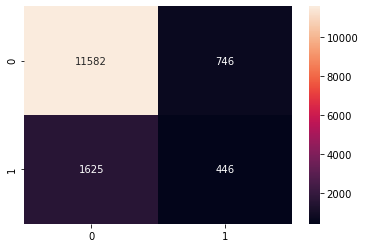

In [156]:
sns.heatmap(metrics.confusion_matrix(pred,test['cart_add']),annot=True,fmt='2.0f')

In [90]:
import shap

In [157]:
train

,cart_add,checkout_order_confirmation,quiz_taken,filters_applied,popular_filters_applied,search_applied,topics_applied,recently_viewed,category_landing_entrypoints
5204,1,0,7,0,0,0,0,0,0
2713,1,1,0,0,0,0,0,0,0
17658,1,0,0,0,17,0,0,0,0
28514,1,0,6,0,0,0,6,0,0
3220,1,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
16329,0,0,0,0,0,0,0,0,0
1760,0,0,0,0,0,0,0,0,0
16869,0,0,0,0,0,0,0,0,0
2105,0,0,0,0,9,9,0,0,0


In [158]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(train.drop(['cart_add','checkout_order_confirmation'],axis=1))

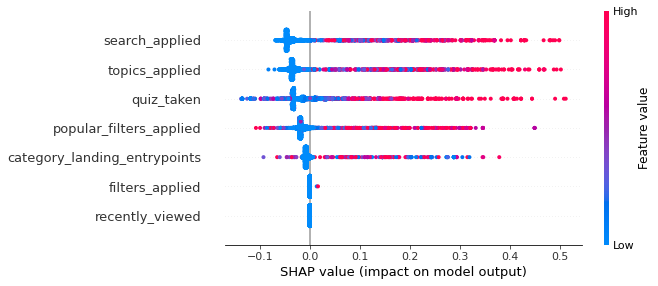

In [159]:
shap.summary_plot(shap_values[1], train.drop(['cart_add','checkout_order_confirmation'],axis=1))

In [124]:
train.shape

(1399, 9)

In [125]:
train.drop(train[train['checkout_order_confirmation']==0].index.tolist()[:500],axis=0,inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
clf = RandomForestClassifier(random_state=47)
# Fit the classifier to the training data
clf.fit(train.drop(['cart_add','checkout_order_confirmation'],axis=1), train['checkout_order_confirmation'])

# Create the predicted tags: pred
pred = clf.predict(test.drop(['cart_add','checkout_order_confirmation'],axis=1))

# Calculate the accuracy score: score
score = metrics.accuracy_score(test['checkout_order_confirmation'], pred)
print('Accuracy is:',score)
f1 = metrics.f1_score(test['checkout_order_confirmation'], pred)
print('F score is:',f1)

Accuracy is: 0.9447878324883673
F score is: 0.03636363636363637


<AxesSubplot:>

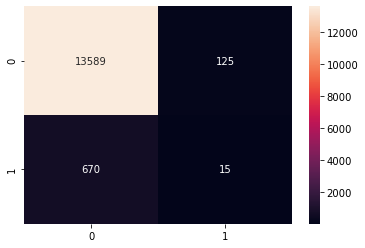

In [127]:
sns.heatmap(metrics.confusion_matrix(pred,test['checkout_order_confirmation']),annot=True,fmt='2.0f')

In [128]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(clf)

# Calculate Shap values
shap_values = explainer.shap_values(train.drop(['cart_add','checkout_order_confirmation'],axis=1))

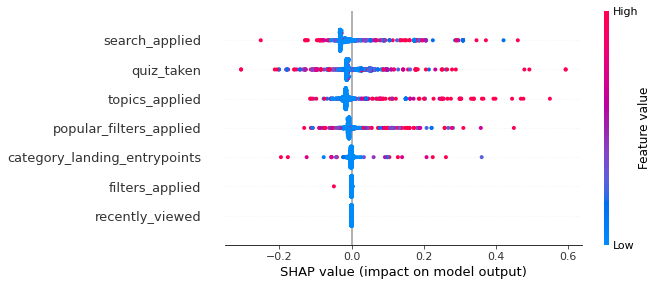

In [129]:
shap.summary_plot(shap_values[1], train.drop(['cart_add','checkout_order_confirmation'],axis=1))